## 1. Environment settup

In [1]:
import io
import os
import json
import zipfile
import urllib

import numpy as np
import pandas as pd
import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role

import boto3
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket here if you wish.
bucket = Session().default_bucket()

# Location to save your custom code in tar.gz format.
custom_code_upload_location = 's3://{}/predmaint_source/customcode'.format(bucket)

# Location where results of model training are saved.
model_artifacts_location = 's3://{}/predmaint_source/artifacts'.format(bucket)

# IAM execution role that gives SageMaker access to resources in your AWS account.
role = get_execution_role()

region = boto3.Session().region_name

## 2. Data download and pre-processing

In [2]:
# Data ingestion - reading the datasets from Azure blob 
# !wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt 
# !wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
# !wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt 
data_folder = 'data'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
urllib.request.urlretrieve('https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip', os.path.join(data_folder, 'CMAPSSData.zip'))
with zipfile.ZipFile(os.path.join(data_folder, 'CMAPSSData.zip'), "r") as zip_ref:
    zip_ref.extractall(data_folder)
    
columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3','s4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14','s15', 's16', 's17', 's18', 's19', 's20', 's21']

### 2-1. Train data

In [3]:
# read training data 
# train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df = pd.read_csv('data/train_FD001.txt', sep=" ", header=None)

# print(train_df.columns)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [4]:
train_df = train_df.sort_values(['id','cycle'])

In [5]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

In [6]:
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


### (Optional) Storing scaler for inference

* In order to use same normalization scalor in your inference, you may store these values

In [7]:
max = min_max_scaler.data_max_
min = min_max_scaler.data_min_

In [8]:
minmax = np.append(min,max).reshape(2,25)
minmax

array([[ 1.00000e+00,  5.18670e+02,  1.30000e+00,  4.68500e+01,
         5.18690e+02,  2.38788e+03,  8.09994e+03,  8.32490e+00,
         3.00000e-02,  3.88000e+02,  2.38800e+03,  1.00000e+02,
         6.41210e+02,  3.81400e+01,  2.28942e+01,  1.57104e+03,
         1.38225e+03,  1.46200e+01,  2.16000e+01,  5.49850e+02,
         2.38790e+03,  9.02173e+03, -8.70000e-03, -6.00000e-04,
         1.00000e+02],
       [ 3.62000e+02,  5.18670e+02,  1.30000e+00,  4.85300e+01,
         5.23380e+02,  2.38856e+03,  8.29372e+03,  8.58480e+00,
         3.00000e-02,  4.00000e+02,  2.38800e+03,  1.00000e+02,
         6.44530e+02,  3.94300e+01,  2.36184e+01,  1.61691e+03,
         1.44149e+03,  1.46200e+01,  2.16100e+01,  5.56060e+02,
         2.38856e+03,  9.24459e+03,  8.70000e-03,  6.00000e-04,
         1.00000e+02]])

In [9]:
inf_scaler = preprocessing.MinMaxScaler()
minmax = [[ 1.00000e+00,  5.18670e+02,  1.30000e+00,  4.68500e+01,
         5.18690e+02,  2.38788e+03,  8.09994e+03,  8.32490e+00,
         3.00000e-02,  3.88000e+02,  2.38800e+03,  1.00000e+02,
         6.41210e+02,  3.81400e+01,  2.28942e+01,  1.57104e+03,
         1.38225e+03,  1.46200e+01,  2.16000e+01,  5.49850e+02,
         2.38790e+03,  9.02173e+03, -8.70000e-03, -6.00000e-04,
         1.00000e+02],
       [ 3.62000e+02,  5.18670e+02,  1.30000e+00,  4.85300e+01,
         5.23380e+02,  2.38856e+03,  8.29372e+03,  8.58480e+00,
         3.00000e-02,  4.00000e+02,  2.38800e+03,  1.00000e+02,
         6.44530e+02,  3.94300e+01,  2.36184e+01,  1.61691e+03,
         1.44149e+03,  1.46200e+01,  2.16100e+01,  5.56060e+02,
         2.38856e+03,  9.24459e+03,  8.70000e-03,  6.00000e-04,
         1.00000e+02]]
inf_scaler.fit(minmax)

MinMaxScaler()

In [10]:
inf_scaler.fit_transform(train_df[cols_normalize])

array([[0.        , 0.        , 0.        , ..., 0.45977011, 0.16666667,
        0.        ],
       [0.00277008, 0.        , 0.        , ..., 0.6091954 , 0.25      ,
        0.        ],
       [0.00554017, 0.        , 0.        , ..., 0.25287356, 0.75      ,
        0.        ],
       ...,
       [0.54570637, 0.        , 0.        , ..., 0.52298851, 0.5       ,
        0.        ],
       [0.54847645, 0.        , 0.        , ..., 0.43678161, 0.75      ,
        0.        ],
       [0.55124654, 0.        , 0.        , ..., 0.31609195, 0.08333333,
        0.        ]])

* You can see the same normalization results

In [11]:
(inf_scaler.fit_transform(train_df[cols_normalize]) - min_max_scaler.fit_transform(train_df[cols_normalize])).sum()

0.0

### 2-2. Test data
* You can increase quality of prediction by using test dataset  
  (However, currently, this notebook is not using this dataset yet.)

In [12]:
# read test data
test_df = pd.read_csv('data/test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [13]:
# read ground truth data
truth_df = pd.read_csv('data/RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [14]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,0.03,392.0,2388.0,100.0,38.86,23.3735,1.0,142,0,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,0.03,393.0,2388.0,100.0,39.02,23.3916,2.0,141,0,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,0.03,393.0,2388.0,100.0,39.08,23.4166,3.0,140,0,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,0.03,391.0,2388.0,100.0,39.00,23.3737,4.0,139,0,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,0.03,390.0,2388.0,100.0,38.99,23.4130,5.0,138,0,0


### 2-3. Store data as .csv

In [15]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

## 3. Training

### 3-1. S3 upload

In [16]:
s3_bucket_resource = boto3.resource('s3').Bucket(bucket)

for i in ['train','test']:
    filename = '{}.csv'.format(i)
    s3_filename = os.path.join('predmaint_data',filename)
    s3_bucket_resource.Object(s3_filename).upload_file(filename)
#     print(s3_filename)


### 3-2. Tensorflow code (Classification)
* Note that this code use 'label1' column as target value

In [17]:
!mkdir script

In [18]:
%%writefile script/train.py

import pandas as pd
import numpy as np
import argparse
import os
import json
import tensorflow as tf
from tensorflow.contrib.eager.python import tfe

tf.enable_eager_execution()
tf.set_random_seed(0)

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, CuDNNLSTM, Activation

# pick a large window size of 50 cycles
sequence_length = 50

# print(os.system('python --version'))

def _parse_args():

    parser = argparse.ArgumentParser()

    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--model_dir', type=str)
    parser.add_argument('--sm-model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--hosts', type=list, default=json.loads(os.environ.get('SM_HOSTS')))
    parser.add_argument('--current-host', type=str, default=os.environ.get('SM_CURRENT_HOST'))
    parser.add_argument('--epochs', type=int, default=30)
    parser.add_argument('--learning_rate', type=float, default=0.01)
    parser.add_argument('--batch_size', type=int, default=200)

    return parser.parse_known_args()

def get_train_data(train_dir):
    # function to reshape features into (samples, time steps, features) 
    def gen_sequence(id_df, seq_length, seq_cols):
        """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
        we need to drop those which are below the window-length. An alternative would be to pad sequences so that
        we can use shorter ones """
        data_array = id_df[seq_cols].values
        num_elements = data_array.shape[0]
        for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
            yield data_array[start:stop, :]
            
    # pick the feature columns 
    sensor_cols = ['s' + str(i) for i in range(1,22)]
    sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
    sequence_cols.extend(sensor_cols)
    
    train_df = pd.read_csv(os.path.join(train_dir,'train.csv'))
    
    # generator for the sequences
    seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
               for id in train_df['id'].unique())
    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
    # function to generate labels
    def gen_labels(id_df, seq_length, label):
        data_array = id_df[label].values
        num_elements = data_array.shape[0]
        return data_array[seq_length:num_elements, :]
    # generate labels
    label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
                 for id in train_df['id'].unique()]
    label_array = np.concatenate(label_gen).astype(np.float32)
#     print('seq_array', seq_array.shape,'label_array', label_array.shape)

    return seq_array, label_array

def get_model(nb_features, nb_out):
    X_in = tf.keras.Input((sequence_length, nb_features))
    X = tf.keras.layers.CuDNNLSTM(
             input_shape=(sequence_length, nb_features),
             units=100,
             return_sequences=True)(X_in)
    X = tf.keras.layers.Dropout(0.2)(X)
    X = tf.keras.layers.CuDNNLSTM(
              units=50,
              return_sequences=False)(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    Y = tf.keras.layers.Dense(units=nb_out, activation='sigmoid')(X)
    
    model = tf.keras.Model(inputs = X_in, outputs = Y, name='PRED_MAINT')

    return model

if __name__ == "__main__":
        
    args, _ = _parse_args()
    
    seq_array, label_array = get_train_data('/opt/ml/input/data/train')
#     seq_array_test, label_array_test = get_train_data('/opt/ml/input/data/test')
    model = get_model(seq_array.shape[2], label_array.shape[1])

    # fit the network
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.train.AdamOptimizer(learning_rate=args.learning_rate), 
                  metrics=['accuracy'])
    model.fit(seq_array, label_array, 
              epochs=args.epochs, 
              batch_size=args.batch_size, 
              validation_data=(seq_array, label_array),
              validation_split=0.1, 
              verbose=0)
#               ,
#               callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, mode='auto')])
    
    # save checkpoint for locally loading in notebook
#     saver = tfe.Saver(model.variables)
#     saver.save(args.model_dir + '/weights.ckpt')
    # create a separate SavedModel for deployment to a SageMaker endpoint with TensorFlow Serving
    tf.contrib.saved_model.save_keras_model(model, args.model_dir)
    
#     print(os.system('ls -al /opt/ml/model/'))
#     print(os.system('ls -al /opt/ml/output/'))
#     print(os.system('ls -al /opt/ml/output/data/'))

Writing script/train.py


### 3-3. Training with SageMaker Tensorflow

In [88]:
from sagemaker.tensorflow import TensorFlow

train_instance_type = 'ml.p3.2xlarge'
hyperparameters = {'epochs': 100, 
                   'batch_size': 128, 
                   'learning_rate': 0.01}

estimator = TensorFlow(entry_point='train.py',
                       source_dir='script',
#                        model_dir=model_artifacts_location,
                       model_dir='/opt/ml/model/',
                       instance_type=train_instance_type,
                       instance_count=1,
                       hyperparameters=hyperparameters,
                       role=role,
                       base_job_name='tf-predmaint',
                       framework_version='1.12.0',
                       py_version='py3',
                       script_mode=True)

- Run training job. (it wil take +15 minutes.)

In [90]:
%%time
train_data = 's3://{}/predmaint_data/train.csv'.format(bucket)
test_data = 's3://{}/predmaint_data/test.csv'.format(bucket)
inputs = {'train':train_data, 'test':test_data}

estimator.fit(inputs)

2021-05-19 08:51:37 Starting - Starting the training job...
2021-05-19 08:52:01 Starting - Launching requested ML instancesProfilerReport-1621414296: InProgress
......
2021-05-19 08:53:01 Starting - Preparing the instances for training.........
2021-05-19 08:54:32 Downloading - Downloading input data...
2021-05-19 08:55:04 Training - Training image download completed. Training in progress..2021-05-19 08:55:07,383 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-05-19 08:55:07,762 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test": "/opt/ml/input/data/test",
        "train": "/opt/ml/input/data/train"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch_size": 128,
        "model_dir": "/opt/ml/model/",
    

## 4. Deploy and check the result

### 4-1. Deploy

In [91]:
predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.p2.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!

### 4-2. Inference test (Classification)

* Extract id 1 events as test dataset 
* Below function is the samoe code of train.py (entry_point script) for dataset generation 

In [92]:
# pick a large window size of 50 cycles
sequence_length = 50
def get_train_data(train_dir):
    # function to reshape features into (samples, time steps, features) 
    def gen_sequence(id_df, seq_length, seq_cols):
        """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
        we need to drop those which are below the window-length. An alternative would be to pad sequences so that
        we can use shorter ones """
        data_array = id_df[seq_cols].values
        num_elements = data_array.shape[0]
        for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
            yield data_array[start:stop, :]
            
    # pick the feature columns 
    sensor_cols = ['s' + str(i) for i in range(1,22)]
    sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
    sequence_cols.extend(sensor_cols)
    
    train_df = pd.read_csv(os.path.join(train_dir,'train.csv'))
    
    # generator for the sequences
    seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
               for id in train_df['id'].unique())
    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
    # function to generate labels
    def gen_labels(id_df, seq_length, label):
        data_array = id_df[label].values
        num_elements = data_array.shape[0]
        return data_array[seq_length:num_elements, :]
    # generate labels
    label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
                 for id in train_df['id'].unique()]
    label_array = np.concatenate(label_gen).astype(np.float32)
#     print('seq_array', seq_array.shape,'label_array', label_array.shape)

    return seq_array, label_array

In [93]:
seq_array, label_array = get_train_data('./')

In [94]:
testset= seq_array[0:141,:]
testset.shape

(141, 50, 25)

* Call the endpoint to see the possibility of failure

In [95]:
predictions = []
for i in range(0,141):
    r = predictor.predict(testset[i:i+1,:])['predictions'][0][0]
    print("Predicted class of {}th window is => {} ".format(i,r))
    predictions.append(r)

Predicted class of 0th window is => 1.16315e-06 
Predicted class of 1th window is => 4.55537e-07 
Predicted class of 2th window is => 2.70385e-07 
Predicted class of 3th window is => 5.93925e-07 
Predicted class of 4th window is => 4.32714e-07 
Predicted class of 5th window is => 2.3964e-07 
Predicted class of 6th window is => 1.4388e-07 
Predicted class of 7th window is => 8.71062e-07 
Predicted class of 8th window is => 2.33108e-07 
Predicted class of 9th window is => 5.96053e-07 
Predicted class of 10th window is => 3.83068e-07 
Predicted class of 11th window is => 3.98681e-07 
Predicted class of 12th window is => 2.31202e-07 
Predicted class of 13th window is => 1.11337e-06 
Predicted class of 14th window is => 6.64599e-07 
Predicted class of 15th window is => 2.34242e-06 
Predicted class of 16th window is => 3.02905e-07 
Predicted class of 17th window is => 2.29929e-07 
Predicted class of 18th window is => 1.03874e-06 
Predicted class of 19th window is => 4.75815e-07 
Predicted cl

* Visulize the result (failure possiibility by running cycle)

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

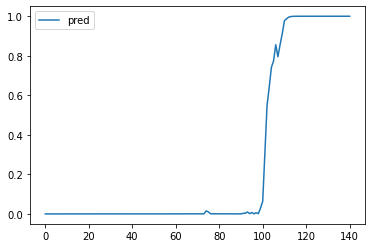

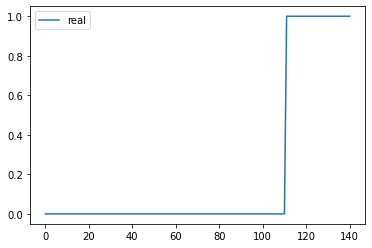

In [97]:
plt.plot(pd.DataFrame(predictions),label='pred')
plt.legend(loc='upper left')
plt.show()
plt.plot(label_array[0:141,:], label='real')
plt.legend(loc='upper left')
plt.show()

### 4-3. Endpoint call test

* For more infomation WRT RealTimePredictor : https://sagemaker.readthedocs.io/en/stable/predictors.html

* Input data format is float list (This code example is transforming numpy array to list)

In [98]:
api_testset = np.asarray(testset).astype(float).tolist()
print("data type: {}, length: {}".format(type(api_testset), len(api_testset)))

data type: <class 'list'>, length: 141


In [99]:
import json
import sagemaker
# from sagemaker.predictor import json_serializer, json_deserializer, RealTimePredictor
sess = sagemaker.Session()

In [100]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer

api_predictor = Predictor(endpoint_name=predictor.endpoint_name, sagemaker_session=sess, serializer=JSONSerializer())
result = api_predictor.predict({'instances': api_testset})
result_json = json.loads(result.decode('utf-8'))

In [101]:
predictions = []
for r in result_json['predictions']:
    predictions.append(r[0])

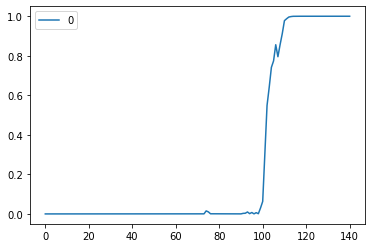

In [102]:
ax = pd.DataFrame(predictions).plot()

### 4-4. Boto3 API test

* You can use same dataset from Classification data
* You can use below hard-coded list for quick api interface test

In [103]:
api_testset = [[[0.4597701,0.16666667,0.0,0.0,0.0,0.18373494,0.40680182,0.30975693,0.0,1.0,0.72624797,0.24242425,0.109755,0.0,0.3690476,0.6332623,0.20588236,0.1996078,0.36398613,0.0,0.33333334,0.0,0.0,0.7131783,0.7246617],
[0.6091954,0.25,0.0,0.002770083,0.0,0.28313252,0.4530194,0.35263336,0.0,1.0,0.62801933,0.21212122,0.1002423,0.0,0.3809524,0.7654584,0.27941176,0.1628135,0.41131204,0.0,0.33333334,0.0,0.0,0.6666667,0.73101354],
[0.25287357,0.75,0.0,0.005540166,0.0,0.3433735,0.36952257,0.37052667,0.0,1.0,0.71014494,0.27272728,0.14004308,0.0,0.25,0.7953092,0.22058824,0.17179276,0.35744518,0.0,0.16666667,0.0,0.0,0.627907,0.6213753],
[0.54022986,0.5,0.0,0.008310249,0.0,0.3433735,0.2561587,0.33119515,0.0,1.0,0.7407407,0.3181818,0.124517635,0.0,0.16666667,0.8891258,0.29411766,0.17488904,0.16660254,0.0,0.33333334,0.0,0.0,0.5736434,0.66238606],
[0.3908046,0.33333334,0.0,0.011080332,0.0,0.3493976,0.25746676,0.40462527,0.0,1.0,0.66827697,0.24242425,0.14995961,0.0,0.2559524,0.74626863,0.23529412,0.17473423,0.40207773,0.0,0.41666666,0.0,0.0,0.58914727,0.7045015],
[0.25287357,0.41666666,0.0,0.013850415,0.0,0.26807228,0.29278395,0.27211344,0.0,1.0,0.77616745,0.18181819,0.12541506,0.0,0.1845238,0.63752663,0.22058824,0.16983177,0.33051175,0.0,0.25,0.0,0.0,0.6511628,0.6527203],
[0.5574713,0.5833333,0.0,0.016620498,0.0,0.38253012,0.46391976,0.26198515,0.0,1.0,0.72302735,0.18181819,0.16781837,0.0,0.30357143,0.77398723,0.22058824,0.1670967,0.27895343,0.0,0.33333334,0.0,0.0,0.74418604,0.667219],
[0.3045977,0.75,0.0,0.019390581,0.0,0.4066265,0.25986484,0.3160027,0.0,1.0,0.64412236,0.15151516,0.08556942,0.0,0.23214285,0.80597013,0.22058824,0.1606461,0.3181993,0.0,0.25,0.0,0.0,0.64341086,0.5749793],
[0.545977,0.5833333,0.0,0.022160664,0.0,0.2740964,0.43470678,0.2118501,0.0,1.0,0.6183575,0.22727273,0.110966526,0.0,0.26190478,0.6609808,0.25,0.13288265,0.18430166,0.0,0.33333334,0.0,0.0,0.70542634,0.7075394],
[0.31034482,0.5833333,0.0,0.024930747,0.0,0.15060242,0.44037497,0.30739364,0.0,1.0,0.60225445,0.22727273,0.13447905,0.0,0.10714286,0.6609808,0.2647059,0.15192486,0.3989996,0.0,0.41666666,0.0,0.0,0.627907,0.79425573],
[0.6034483,0.25,0.0,0.02770083,0.0,0.32228917,0.23348594,0.31043214,0.0,1.0,0.75523347,0.22727273,0.12510096,0.0,0.17857143,0.5778252,0.19117647,0.20972237,0.41977683,0.0,0.33333334,0.0,0.0,0.62015504,0.8070975],
[0.59195405,0.6666667,0.0,0.030470913,0.0,0.2560241,0.26967517,0.3021607,0.0,1.0,0.7520129,0.28787878,0.12402405,0.0,0.19642857,0.663113,0.20588236,0.17705646,0.26510197,0.0,0.25,0.0,0.0,0.7131783,0.6514775],
[0.3908046,0.8333333,0.0,0.033240996,0.0,0.560241,0.24307826,0.31363943,0.0,1.0,0.57809985,0.33333334,0.11258189,0.0,0.31547618,0.673774,0.29411766,0.14531943,0.34744132,0.0,0.41666666,0.0,0.0,0.6124031,0.5267882],
[0.55172414,0.5,0.0,0.03601108,0.0,0.3433735,0.47765425,0.28544903,0.0,1.0,0.7455717,0.28787878,0.11504981,0.0,0.35119048,0.63539445,0.1764706,0.17798534,0.2751058,0.0,0.41666666,0.0,0.0,0.8062016,0.6743993],
[0.39655173,0.25,0.0,0.038781162,0.0,0.36746988,0.27861348,0.33558407,0.0,1.0,0.61030596,0.3181818,0.13681234,0.0,0.26785713,0.8123667,0.29411766,0.14253277,0.36552522,0.0,0.25,0.0,0.0,0.65891474,0.62938416],
[0.5344828,0.9166667,0.0,0.041551247,0.0,0.27710843,0.36930457,0.37559083,0.0,1.0,0.6586151,0.22727273,0.12388944,0.0,0.23214285,0.5970149,0.27941176,0.18665497,0.26433244,0.0,0.33333334,0.0,0.0,0.64341086,0.77437174],
[0.5114943,0.6666667,0.0,0.04432133,0.0,0.41265061,0.30346632,0.2987846,0.0,1.0,0.63607085,0.24242425,0.14892758,0.0,0.16071428,0.6823028,0.23529412,0.19264114,0.49749905,0.0,0.33333334,0.0,0.0,0.51937985,0.60439104],
[0.3218391,0.41666666,0.0,0.047091413,0.0,0.4246988,0.43601483,0.23413235,0.0,1.0,0.7004831,0.22727273,0.124831736,0.0,0.21428572,0.6545842,0.27941176,0.1692125,0.29973066,0.0,0.33333334,0.0,0.0,0.5813953,0.6966308],
[0.68390805,0.25,0.0,0.049861494,0.0,0.1746988,0.36014825,0.3055368,0.0,1.0,0.69726247,0.21212122,0.14475456,0.0,0.32738096,0.6823028,0.22058824,0.15063474,0.41246635,0.0,0.25,0.0,0.0,0.5116279,0.62441313],
[0.28735632,0.5833333,0.0,0.05263158,0.0,0.5512048,0.21953346,0.38791358,0.0,1.0,0.7987118,0.22727273,0.108453736,0.0,0.22023809,0.7206823,0.20588236,0.15362783,0.3697576,0.0,0.33333334,0.0,0.0,0.68992245,0.7288042],
[0.43103448,0.5833333,0.0,0.05540166,0.0,0.3493976,0.32766515,0.2680621,0.0,1.0,0.68115944,0.3181818,0.118549764,0.0,0.17857143,0.7953092,0.29411766,0.17586954,0.3078107,0.0,0.33333334,0.0,0.0,0.7364341,0.57428885],
[0.5114943,0.5,0.0,0.058171745,0.0,0.4698795,0.4772182,0.3092505,0.0,1.0,0.6086956,0.21212122,0.17715158,0.0,0.23214285,0.7057569,0.22058824,0.15724017,0.30203924,0.0,0.33333334,0.0,0.0,0.60465115,0.6697045],
[0.6954023,0.25,0.0,0.060941827,0.0,0.2801205,0.3738827,0.21100608,0.0,1.0,0.66505635,0.22727273,0.110158846,0.0,0.23809524,0.6034115,0.25,0.14428733,0.3813005,0.0,0.33333334,0.0,0.0,0.62015504,0.7760287],
[0.44252872,0.75,0.0,0.06371191,0.0,0.35240963,0.43143666,0.27954084,0.0,1.0,0.58615136,0.33333334,0.09885129,0.0,0.35119048,0.7334755,0.22058824,0.17514707,0.24701808,0.0,0.33333334,0.0,0.0,0.6666667,0.6564485],
[0.6321839,0.16666667,0.0,0.06648199,0.0,0.4698795,0.50272506,0.28933153,0.0,1.0,0.66827697,0.18181819,0.14551736,0.0,0.30357143,0.8251599,0.20588236,0.18923521,0.25702193,0.0,0.41666666,0.0,0.0,0.627907,0.73819387],
[0.5,0.6666667,0.0,0.06925208,0.0,0.28614458,0.39328536,0.23328832,0.0,1.0,0.68599033,0.25757575,0.11388315,0.0,0.24404761,0.7654584,0.2647059,0.16105893,0.38899577,0.0,0.5,0.0,0.0,0.55813956,0.7190003],
[0.43103448,0.16666667,0.0,0.07202216,0.0,0.37048194,0.4235884,0.33068871,0.0,1.0,0.6795491,0.18181819,0.11769721,0.0,0.30952382,0.7057569,0.36764705,0.17886263,0.30665642,0.0,0.41666666,0.0,0.0,0.65891474,0.76360124],
[0.36206895,0.9166667,0.0,0.07479224,0.0,0.3433735,0.25724876,0.2849426,0.0,1.0,0.7777778,0.33333334,0.126133,0.0,0.33333334,0.8272921,0.29411766,0.14119104,0.41323587,0.0,0.16666667,0.0,0.0,0.6744186,0.5383872],
[0.5689655,0.41666666,0.0,0.077562325,0.0,0.21084337,0.3006322,0.3163403,0.0,1.0,0.7085346,0.22727273,0.12895988,0.0,0.23214285,0.79317695,0.2647059,0.17091547,0.36167756,0.0,0.41666666,0.0,0.0,0.6124031,0.6427782],
[0.37356323,0.5,0.0,0.08033241,0.0,0.29819277,0.49008065,0.23345712,0.0,1.0,0.7278583,0.25757575,0.107197344,0.0,0.32738096,0.74626863,0.1764706,0.19568583,0.3139669,0.0,0.16666667,0.0,0.0,0.70542634,0.713615],
[0.5804598,0.9166667,0.0,0.083102494,0.0,0.24397591,0.28646174,0.24729912,0.0,1.0,0.68921095,0.27272728,0.16624787,0.0,0.33333334,0.69509596,0.2647059,0.13076685,0.32897267,0.0,0.33333334,0.0,0.0,0.62015504,0.6090859],
[0.52873564,0.25,0.0,0.085872576,0.0,0.33734939,0.4434271,0.3057056,0.0,1.0,0.8228663,0.21212122,0.13120344,0.0,0.23809524,0.68869936,0.27941176,0.15357623,0.34590226,0.0,0.33333334,0.0,0.0,0.68217057,0.8363712],
[0.25862068,0.16666667,0.0,0.08864266,0.0,0.45180723,0.37846085,0.3406482,0.0,1.0,0.76650566,0.21212122,0.113972895,0.0,0.2559524,0.6865672,0.29411766,0.17793374,0.19392073,0.0,0.33333334,0.0,0.0,0.53488374,0.63021266],
[0.5862069,0.41666666,0.0,0.091412745,0.0,0.4006024,0.22738174,0.30773127,0.0,1.0,0.7165862,0.1969697,0.110966526,0.0,0.3690476,0.64179105,0.30882353,0.1376303,0.4232397,0.0,0.33333334,0.0,0.0,0.51937985,0.57304615],
[0.51724136,0.6666667,0.0,0.09418283,0.0,0.37048194,0.41334206,0.3502701,0.0,1.0,0.7165862,0.21212122,0.10782554,0.0,0.27380952,0.65245205,0.19117647,0.20760657,0.45440555,0.0,0.25,0.0,0.0,0.76744187,0.72107154],
[0.4770115,0.33333334,0.0,0.09695291,0.0,0.4006024,0.23283191,0.3931465,0.0,1.0,0.7536232,0.16666667,0.102441,0.0,0.23809524,0.77398723,0.23529412,0.16792239,0.3836091,0.0,0.33333334,0.0,0.0,0.55813956,0.74095553],
[0.4770115,0.5,0.0,0.09972299,0.0,0.23493975,0.17593198,0.2810601,0.0,1.0,0.7697263,0.25757575,0.15126088,0.0,0.26190478,0.76759064,0.23529412,0.16518733,0.3435937,0.0,0.33333334,0.0,0.0,0.65891474,0.7470312],
[0.39655173,0.33333334,0.0,0.10249308,0.0,0.21686748,0.40462175,0.2911884,0.0,1.0,0.7809984,0.27272728,0.15049808,0.0,0.25,0.7953092,0.29411766,0.18923521,0.3497499,0.0,0.33333334,0.0,0.0,0.7131783,0.8044739],
[0.3275862,0.41666666,0.0,0.10526316,0.0,0.24096386,0.26531503,0.31127617,0.0,1.0,0.66344607,0.18181819,0.13474827,0.0,0.16071428,0.75479746,0.25,0.16446486,0.34282416,0.0,0.33333334,0.0,0.0,0.43410853,0.65686274],
[0.5,0.16666667,0.0,0.10803324,0.0,0.31024095,0.24068019,0.32950708,0.0,1.0,0.7600644,0.24242425,0.14022256,0.0,0.2857143,0.67164177,0.19117647,0.16043967,0.2058484,0.0,0.33333334,0.0,0.0,0.5426357,0.6665286],
[0.6896552,0.8333333,0.0,0.11080332,0.0,0.35843372,0.44190103,0.353815,0.0,1.0,0.6231884,0.24242425,0.122318946,0.0,0.14285715,0.7206823,0.22058824,0.19682114,0.43131974,0.0,0.33333334,0.0,0.0,0.76744187,0.75973487],
[0.52873564,0.16666667,0.0,0.11357341,0.0,0.2740964,0.29692608,0.3229237,0.0,1.0,0.6586151,0.27272728,0.15853001,0.0,0.3809524,0.75479746,0.25,0.1596656,0.3416699,0.0,0.33333334,0.0,0.0,0.6666667,0.663905],
[0.3448276,0.9166667,0.0,0.11634349,0.0,0.31024095,0.44647917,0.40175557,0.0,1.0,0.6167472,0.1969697,0.16220947,0.0,0.2797619,0.86353946,0.30882353,0.1407782,0.3151212,0.0,0.33333334,0.0,0.0,0.65891474,0.5807788],
[0.49425286,0.6666667,0.0,0.11911357,0.0,0.21686748,0.3466318,0.31988522,0.0,1.0,0.69243157,0.21212122,0.112806246,0.0,0.35714287,0.7697228,0.1764706,0.16260707,0.36629474,0.0,0.33333334,0.0,0.0,0.7131783,0.8024027],
[0.42528737,0.5,0.0,0.12188365,0.0,0.39759037,0.24809243,0.28544903,0.0,1.0,0.64090174,0.27272728,0.17315803,0.0,0.35714287,0.64818764,0.25,0.14640313,0.32704887,0.0,0.41666666,0.0,0.0,0.503876,0.6905551],
[0.51724136,0.5833333,0.0,0.12465374,0.0,0.36746988,0.37606278,0.32106686,0.0,1.0,0.6296296,0.24242425,0.17342727,0.0,0.20833333,0.7100213,0.29411766,0.14846733,0.28010774,0.0,0.41666666,0.0,0.0,0.6124031,0.66321456],
[0.5,0.9166667,0.0,0.12742382,0.0,0.30120483,0.20231088,0.34841323,0.0,1.0,0.7294686,0.24242425,0.13600467,0.0,0.22023809,0.67164177,0.25,0.1355661,0.27856869,0.0,0.33333334,0.0,0.0,0.65891474,0.81897265],
[0.6091954,0.5833333,0.0,0.1301939,0.0,0.20481928,0.38085896,0.28544903,0.0,1.0,0.6714976,0.27272728,0.10558198,0.0,0.32738096,0.6865672,0.2647059,0.15507276,0.43362832,0.0,0.33333334,0.0,0.0,0.62015504,0.65009665],
[0.41954023,0.9166667,0.0,0.13296399,0.0,0.30722892,0.29016787,0.26181635,0.0,1.0,0.705314,0.25757575,0.1297227,0.0,0.22023809,0.5714286,0.23529412,0.18340386,0.34705657,0.0,0.33333334,0.0,0.0,0.7131783,0.7671914],
[0.31609195,0.41666666,0.0,0.13573407,0.0,0.4698795,0.38042292,0.36073598,0.0,1.0,0.65539455,0.24242425,0.12056897,0.0,0.3690476,0.7761194,0.30882353,0.14119104,0.33358985,0.0,0.33333334,0.0,0.0,0.5503876,0.7130627]]]


In [104]:
# ENDPOINT_NAME = 'tf-techsummit-predmain-2019-07-02-15-28-11-188'
ENDPOINT_NAME = predictor.endpoint_name
runtime= boto3.client('runtime.sagemaker')

In [105]:
payload = {'instances': api_testset}
payload_str = json.dumps(payload)

In [107]:
response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                  ContentType='application/json',
                                  Body=payload_str.encode())
x = json.loads(response['Body'].read().decode())
x['predictions'][0][0]

1.16315e-06

## 5. Applying Regression model with same dataset

### 5-1. entry_point script (Regression)

* Note that this code use 'RUL' column as target variable
* RUL normalization step is added and loss function is changed to mean_squred_error

In [42]:
%%writefile script/train-rul.py

import pandas as pd
import numpy as np
import argparse
import os
import json
import tensorflow as tf
from tensorflow.contrib.eager.python import tfe

tf.enable_eager_execution()
tf.set_random_seed(0)

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, CuDNNLSTM, Activation

# pick a large window size of 50 cycles
sequence_length = 50

# print(os.system('python --version'))

def _parse_args():

    parser = argparse.ArgumentParser()

    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--model_dir', type=str)
    parser.add_argument('--sm-model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--hosts', type=list, default=json.loads(os.environ.get('SM_HOSTS')))
    parser.add_argument('--current-host', type=str, default=os.environ.get('SM_CURRENT_HOST'))
    parser.add_argument('--epochs', type=int, default=30)
    parser.add_argument('--learning_rate', type=float, default=0.01)
    parser.add_argument('--batch_size', type=int, default=200)

    return parser.parse_known_args()

def get_train_data(train_dir):
    # function to reshape features into (samples, time steps, features) 
    def gen_sequence(id_df, seq_length, seq_cols):
        """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
        we need to drop those which are below the window-length. An alternative would be to pad sequences so that
        we can use shorter ones """
        data_array = id_df[seq_cols].values
        num_elements = data_array.shape[0]
        for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
            yield data_array[start:stop, :]
            
    # pick the feature columns 
    sensor_cols = ['s' + str(i) for i in range(1,22)]
    sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
    sequence_cols.extend(sensor_cols)
    
    train_df = pd.read_csv(os.path.join(train_dir,'train.csv'))
    
    # generator for the sequences
    seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
               for id in train_df['id'].unique())
    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
    # function to generate labels
    def gen_labels(id_df, seq_length, label):
        data_array = id_df[label].values
        num_elements = data_array.shape[0]
        return data_array[seq_length:num_elements, :]
    
    # generate labels
    label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
                 for id in train_df['id'].unique()]
    label_array = np.concatenate(label_gen).astype(np.float32)/300.
    print('seq_array', seq_array.shape,'label_array', label_array.shape)

    return seq_array, label_array


def get_model(nb_features, nb_out):
    X_in = tf.keras.Input((sequence_length, nb_features))
    X = tf.keras.layers.CuDNNLSTM(
             input_shape=(sequence_length, nb_features),
             units=512,
             return_sequences=True)(X_in)
    X = tf.keras.layers.Dropout(0.2)(X)
    X = tf.keras.layers.CuDNNLSTM(
             units=256,
             return_sequences=False)(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    Y = tf.keras.layers.Dense(units=nb_out)(X)
    
    model = tf.keras.Model(inputs = X_in, outputs = Y, name='PRED_MAINT_RUL')
    model.summary()
    return model

if __name__ == "__main__":
        
    args, _ = _parse_args()
    
    seq_array, label_array = get_train_data('/opt/ml/input/data/train')
#     seq_array_test, label_array_test = get_train_data('/opt/ml/input/data/test')
    model = get_model(seq_array.shape[2], label_array.shape[1])
    print(label_array[0])
    # fit the network
    model.compile(loss='mean_squared_error',
                  optimizer=tf.train.AdamOptimizer(learning_rate=args.learning_rate), 
                  metrics=['mean_squared_error'])
#                   metrics=['mean_squared_error'])
    model.fit(seq_array, label_array, 
              epochs=args.epochs, 
              batch_size=args.batch_size, 
#               validation_data=(seq_array, label_array),
              validation_split=0.2, 
              verbose=2)
#               ,
#               callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, mode='auto')])

    # save checkpoint for locally loading in notebook
#     saver = tfe.Saver(model.variables)
#     saver.save(args.model_dir + '/weights.ckpt')
    # create a separate SavedModel for deployment to a SageMaker endpoint with TensorFlow Serving
    tf.contrib.saved_model.save_keras_model(model, args.model_dir)
    
#     print(os.system('ls -al /opt/ml/model/'))
#     print(os.system('ls -al /opt/ml/output/'))
#     print(os.system('ls -al /opt/ml/output/data/'))

Writing script/train-rul.py


### 5-2. Training 
- Run training job (it will take 1+hour)

In [108]:
train_instance_type = 'ml.p3.2xlarge'
hyperparameters_rul = {'epochs': 500, 
                   'batch_size': 50, 
                   'learning_rate': 0.001}

estimator_rul = TensorFlow(entry_point='train-rul.py',
                       source_dir='script',
#                        model_dir=model_artifacts_location,
                       model_dir='/opt/ml/model/',
                       instance_type=train_instance_type,
                       instance_count=1,
                       hyperparameters=hyperparameters_rul,
                       role=role,
                       base_job_name='tf-techsummit-predmaint-rul',
                       framework_version='1.12.0',
                       py_version='py3',
                       script_mode=True)

In [61]:
%%time
train_data = 's3://{}/techsummit/predmaint_data/train.csv'.format(bucket)
test_data = 's3://{}/techsummit/predmaint_data/test.csv'.format(bucket)
inputs = {'train':train_data, 'test':test_data}

estimator_rul.fit(inputs, wait=True)

2021-05-19 06:45:37 Starting - Starting the training job...
2021-05-19 06:46:01 Starting - Launching requested ML instancesProfilerReport-1621406737: InProgress
......
2021-05-19 06:47:01 Starting - Preparing the instances for training.........
2021-05-19 06:48:34 Downloading - Downloading input data...
2021-05-19 06:49:04 Training - Training image download completed. Training in progress..2021-05-19 06:49:08,094 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-05-19 06:49:08,531 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test": "/opt/ml/input/data/test",
        "train": "/opt/ml/input/data/train"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch_size": 50,
        "model_dir": "/opt/ml/model/",
     

### 5-3. Endpoint test (Regression)

In [62]:
predictor_rul = estimator_rul.deploy(initial_instance_count=1,instance_type='ml.p2.xlarge')
# predictor = estimator.deploy(initial_instance_count=1,
#                              instance_type='ml.c5.xlarge',
#                              accelerator_type='ml.eia1.medium')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!

In [87]:
ep_rul = predictor_rul.endpoint_name

In [65]:
def get_train_data_rul(train_dir):
    # function to reshape features into (samples, time steps, features) 
    def gen_sequence(id_df, seq_length, seq_cols):
        """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
        we need to drop those which are below the window-length. An alternative would be to pad sequences so that
        we can use shorter ones """
        data_array = id_df[seq_cols].values
        num_elements = data_array.shape[0]
        for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
            yield data_array[start:stop, :]
            
    # pick the feature columns 
    sensor_cols = ['s' + str(i) for i in range(1,22)]
    sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
    sequence_cols.extend(sensor_cols)
    
    train_df = pd.read_csv(os.path.join(train_dir,'train.csv'))
    
    # generator for the sequences
    seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
               for id in train_df['id'].unique())
    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
    # function to generate labels
    def gen_labels(id_df, seq_length, label):
        data_array = id_df[label].values
        num_elements = data_array.shape[0]
        return data_array[seq_length:num_elements, :]
    
    # generate labels
    label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
                 for id in train_df['id'].unique()]
    label_array = np.concatenate(label_gen).astype(np.float32)/300.
    print('seq_array', seq_array.shape,'label_array', label_array.shape)

    return seq_array, label_array

In [66]:
seq_array_rul, label_array_rul = get_train_data_rul('./')
testset_rul= seq_array_rul[0:141,:]
testset_rul.shape

seq_array (15631, 50, 25) label_array (15631, 1)


(141, 50, 25)

In [77]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer

api_predictor_rul = Predictor(endpoint_name=ep_rul, sagemaker_session=sess, serializer=JSONSerializer())
result_rul = api_predictor_rul2.predict({'instances': api_testset})
result_rul_json = json.loads(result_rul2.decode('utf-8'))

In [78]:
result_rul_list = []
for i in range(0,141):
    r = api_predictor_rul.predict({'instances': testset_rul[i:i+1,:]})
    j = json.loads(r.decode('utf-8'))['predictions'][0][0]
#     print("Predicted RUL of {0:d}th window is => {1:.4f} and real RUL is => {2:.4f} ".format(i,j*300, label_array_rul[i,:][0]*300))
    result_rul_list.append(j*300)

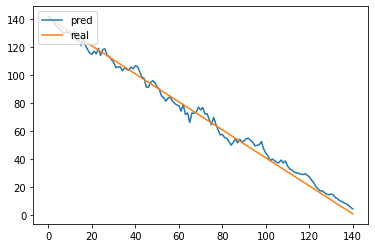

In [79]:
plt.plot(pd.DataFrame(result_rul_list),label='pred')
plt.legend(loc='upper left')

plt.plot(label_array_rul[0:141,:]*300, label='real')
plt.legend(loc='upper left')
plt.show()

## 6. Delete resources

#### Delete endpoint

In [86]:
sagemaker.Session().delete_endpoint(predictor.endpoint_name)

In [85]:
sagemaker.Session().delete_endpoint(predictor_rul.endpoint_name)

* S3 data and notebook instance 삭제 (console)